## Bike-rental volume prediction

The purpose of this notebook is to provide an illustration of how the freshq algorithm can be implemented to aid in the forecasting the value of a target variable without the implementation of data rolling and for data which contains inconsistent evenly spaced data points.

## Loading library scripts and data

In the following cell the functions related to the FreshQ library are loaded in the 1st line while preprocessing functions used within the notebook are loaded from the folder mlutils

In [1]:
\l ml/init.q
\l graphics.q
\c 15 100

Load in data pertaining to a bike sharing scheme in Washington DC between 2011-2012 (This data was obtained from kaggle at: https://www.kaggle.com/marklvl/bike-sharing-dataset).

Our goal is to use the hourly data from the current day to predict if the last hour of the next day will be busier or quieter than the last hour of today.

This use case while slightly contrived and chosen to show the operation of this this algorithm, it could potentially useful in allowing an employer to anticipate if extra staff are required for the next business day, which could save on costs.

In [2]:
tabinit:("IDIIIIIIIIFFFFIII";enlist ",") 0:`:SampleDatasets/bike_rental.csv

/drop columns which contain zero variance as these would not be useful for use in a machine learning algorithm.
show tabinit:flip (where 0=var each flip tabinit) _ flip tabinit

instant dteday     season yr mnth hr holiday weekday workingday weathersit temp atemp  hum  winds..
-------------------------------------------------------------------------------------------------..
1       2011.01.01 1      0  1    0  0       6       0          1          0.24 0.2879 0.81 0    ..
2       2011.01.01 1      0  1    1  0       6       0          1          0.22 0.2727 0.8  0    ..
3       2011.01.01 1      0  1    2  0       6       0          1          0.22 0.2727 0.8  0    ..
4       2011.01.01 1      0  1    3  0       6       0          1          0.24 0.2879 0.75 0    ..
5       2011.01.01 1      0  1    4  0       6       0          1          0.24 0.2879 0.75 0    ..
6       2011.01.01 1      0  1    5  0       6       0          2          0.24 0.2576 0.75 0.089..
7       2011.01.01 1      0  1    6  0       6       0          1          0.22 0.2727 0.8  0    ..
8       2011.01.01 1      0  1    7  0       6       0          1          0.2  0.2576 0.86 0    ..


---

## Set the target values for forecasting

Next we set the target which will be estimated from the dataset. In this case we are attempting to predict if the number of bike rentals in the last hour of business will be higher or lower tomorrow than it was today.

In [3]:
lasthour:value exec last cnt by dteday from tabinit
targets:lasthour>prev lasthour

## Naive solution

Under the naive solution i.e choosing that the number of rentals price will only ever increase we would be correct ~56% of the time, as such if our procedure and algorithm have provided us with new insights into the data our predictions will be >56% on a consistent basis. 

In [4]:
update pcnt:100*num%sum num from select num:count i by target from ([]target:targets)

target| num pcnt    
------| ------------
0     | 319 43.63885
1     | 412 56.36115


## Assign extracted features and complete extraction

In [5]:
/ in this example we look only at features of the data alone with no parameters

show singleinputfeatures:.fresh.getsingleinputfeatures[]

\t tabraw:.fresh.createfeatures[tabinit;`dteday;2_ cols tabinit;singleinputfeatures]
show tabraw
-1"The number of rows in the data is: ",string count tabraw;
-1"The number of targets which are to be predicted is: ",string count lasthour;

absenergy     | {x wsum x}
abssumchange  | {sum abs 1_deltas x}
count         | {count x}
countabovemean| {sum x>avg x}
countbelowmean| {sum x<avg x}
firstmax      | {(x?max x)%count x}
firstmin      | {(x?min x)%count x}
hasdup        | {count[x]<>count distinct x}
hasdupmax     | {1<sum x=max x}
hasdupmin     | {1<sum x=min x}
kurtosis      | {((n-1)%(n-2)*n-3)*((n+1)*n*sum[k2*k2]%s*s:sum k2:k*k:x-avg x)+3*1-n:count x}
lastmax       | {(last where x=max x)%count x}
..


1124


dteday    | absenergy_season absenergy_yr absenergy_mnth absenergy_hr absenergy_holiday absenergy..
----------| -------------------------------------------------------------------------------------..
2011.01.01| 24               0            24             4324         0                 864      ..
2011.01.02| 23               0            23             4299         0                 0        ..
2011.01.03| 22               0            22             4311         0                 22       ..
2011.01.04| 23               0            23             4315         0                 92       ..
2011.01.05| 23               0            23             4315         0                 207      ..
2011.01.06| 23               0            23             4315         0                 368      ..
2011.01.07| 23               0            23             4315         0                 575      ..
2011.01.08| 24               0            24             4324         0                 864      ..


## Complete feature significance tests

Upon completion of the feature extraction algorithm the importance of each of the features can be determined through the statistical tests contained in the .fresh.significantfeatures function. This will reduce the number of features used by the machine learning algorithm in making its prediction.

In [6]:
show tabreduced:key[tabraw]!.fresh.significantfeatures[value tabraw;targets]
-1 "The number of columns in the initial dataset is: ",string count cols tabinit;
-1 "The number of columns in the unfiltered dataset is: ",string count cols tabraw;
-1 "The number of columns in the filtered dataset is: ",string count cols tabreduced;

dteday    | absenergy_weekday absenergy_workingday absenergy_casual absenergy_registered absenerg..
----------| -------------------------------------------------------------------------------------..
2011.01.01| 864               0                    9371             28260                67473   ..
2011.01.02| 0                 0                    1607             32820                47413   ..
2011.01.03| 22                22                   1188             113917               132713  ..
2011.01.04| 92                23                   1268             166348               184990  ..
2011.01.05| 207               23                   542              172722               186408  ..
2011.01.06| 368               23                   708              169622               185510  ..
2011.01.07| 575               23                   1708             141026               167920  ..
2011.01.08| 864               0                    442              52931                62251   ..


### Data formatting

The data must now be converted to a matrix from a table in order to allow it to be passed to a machine learning algorithm for training. The function `.ml.infreplace` is used here to replace infinities within the data with the maximum or minimum value of the data depending on if the infinity is positive or negative

In [7]:
fitvalsfilter:0^flip value flip value tabreduced
fitunfilter:0^flip value flip .ml.infreplace[value tabraw]

---

## Training the model

Below we initialize the model with a random forest classifier with 200 estimators, this should allow us to compare the classifications when run on filtered vs unfiltered datasets. The addition of ``` `verbose pykw 1 ``` to the definition of the Random Forest Classifier allows us to show the difference in time needed to train the model in both the filtered and unfiltered cases.

In [8]:
clf:.p.import[`sklearn.ensemble][`:RandomForestClassifier][`n_estimators pykw 200;`random_state pykw 42]
classreport:.p.import[`sklearn.metrics]`:classification_report

### Fit data to the models and make predictions

In [9]:
seed:"i"$.z.t
dict1:.ml.traintestsplitseed[fitunfilter;targets;0.2;seed];
dict2:.ml.traintestsplitseed[fitvalsfilter;targets;0.2;seed];

clf[`:fit][dict1[`xtrain];dict1[`ytrain]]`;
pred1:clf[`:predict][dict1[`xtest]]`

clf[`:fit][dict2[`xtrain];dict2[`ytrain]]`;
pred2:clf[`:predict][dict2[`xtest]]`


## Results

Given that predictions of the classifications given to the whether or not the last hour of work will be busier than today it is possible to test the number of misclassifications which have been made from our model depending on if the features which are being used for classification have undergone filtering or have been used directly following featyre extraction.

In [10]:
print classreport[dict1[`ytest];pred1]`
-1"The number of misclassifications in the unfiltered dataset is: ",string sum dict1[`ytest]<>pred1;
-1"The accuracy in the filtered dataset is: ",string .ml.accuracy[dict1[`ytest];pred1];
-1"_______________________________________________________________";

print classreport[dict2[`ytest];pred2]`
-1"The number of misclassifications in the filtered dataset is: ",string sum dict2[`ytest]<>pred2;
-1"The accuracy in the unfiltered dataset is: ",string .ml.accuracy[dict2[`ytest];pred2];
-1"_______________________________________________________________";

             precision    recall  f1-score   support

      False       0.80      0.62      0.70        64
       True       0.75      0.88      0.81        83

avg / total       0.77      0.77      0.76       147

The number of misclassifications in the unfiltered dataset is: 34
The accuracy in the filtered dataset is: 0.7687075
_______________________________________________________________
             precision    recall  f1-score   support

      False       0.76      0.66      0.71        64
       True       0.76      0.84      0.80        83

avg / total       0.76      0.76      0.76       147

The number of misclassifications in the filtered dataset is: 35
The accuracy in the unfiltered dataset is: 0.7619048
_______________________________________________________________


0| 40 10
1| 24 73


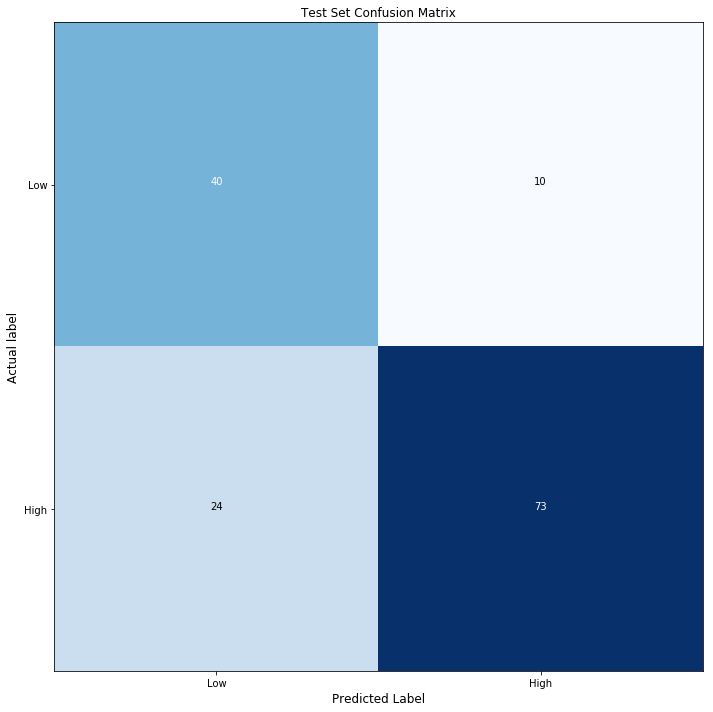

In [11]:
show cnfM:.ml.cfm[dict1[`ytest];pred1]
.ml.displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]

## Conclusions

In conclusion as can be seen from the above results the use of a random forest classifier was useful in allowing for the classification of next day last hour business vs previous day, to be more consistent than simply choosing one case to always be true.

It should also be noted that the quality of results garnered from the running of the classifications depends on the location that the data is split. This is an inherent problem in predicting on human behaviour influenced systems as it is difficult to predict on outlying cases which have a non repeating signature.

---